In [3]:
from config import N, A, b, l, u, M, COV_MATRIX, RISK_F, RISK_ABS, SINGLE_ABS, L1_ABS, SIGMA_ABS
from model_factory import build_market_neutral_model
model = build_market_neutral_model(N, A, b, l, u, RISK_F, RISK_ABS, SINGLE_ABS, L1_ABS, COV_MATRIX, SIGMA_ABS)

Restricted license - for non-production use only - expires 2026-11-23


In [4]:
from config import DATASET_DICT_PATH
from io_utils import load_dataset_dict, create_dataset_from_dict
dataset_dict = load_dataset_dict(DATASET_DICT_PATH)
dataset = create_dataset_from_dict(dataset_dict, model)

/Users/tarothousand/Library/Python/3.11/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


>>> Precomputed mode enabled. Skipping time series processing and solution computation.


In [5]:
from config import K, HIDDEN_DIM, LSTM_HIDDEN_DIM, DROPOUT_RATE, DEVICE
from architecture import TwoLayerLSTM
lstm = TwoLayerLSTM(k=K, hidden_dim=HIDDEN_DIM, lstm_hidden_dim=LSTM_HIDDEN_DIM, dropout_rate=DROPOUT_RATE).to(DEVICE)
print("Model architecture:")
for name, param in lstm.named_parameters():
    print(f"{name:30s} | Shape: {param.data.shape} | Parameters: {param.numel()} | require_grad: {param.requires_grad}")
    print(f"Mean Value: {param.data.mean()} | Grad: {param.grad}")
    print("-" * 80)

Model architecture:
lstm.weight_ih_l0              | Shape: torch.Size([256, 6]) | Parameters: 1536 | require_grad: True
Mean Value: -0.002579850610345602 | Grad: None
--------------------------------------------------------------------------------
lstm.weight_hh_l0              | Shape: torch.Size([256, 64]) | Parameters: 16384 | require_grad: True
Mean Value: -0.00115392473526299 | Grad: None
--------------------------------------------------------------------------------
lstm.bias_ih_l0                | Shape: torch.Size([256]) | Parameters: 256 | require_grad: True
Mean Value: 0.008036967366933823 | Grad: None
--------------------------------------------------------------------------------
lstm.bias_hh_l0                | Shape: torch.Size([256]) | Parameters: 256 | require_grad: True
Mean Value: 0.001899502007290721 | Grad: None
--------------------------------------------------------------------------------
fc_layers.0.weight             | Shape: torch.Size([64]) | Parameters: 64

In [14]:
from sklearn.model_selection import train_test_split
from data_loader import get_data_loaders, device_loader
# 创建 Subset 类
from torch.utils.data import Subset

indices = list(range(len(dataset)))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)
dataset_train = Subset(dataset, train_indices)
dataset_test = Subset(dataset, test_indices)
loader_train, loader_test = get_data_loaders(dataset_train, dataset_test)

In [15]:
from train import trainModel
import pyepo
spop = pyepo.func.SPOPlus(model)
loss_log, loss_log_regret = trainModel(
    lstm, 
    loss_func=spop, 
    method_name="spo+",
    loader_train=loader_train,
    loader_test=loader_test,
    market_neutral_model=model,
    num_epochs=5,  # Increased for better convergence
    lr=1e-3        # Adjusted learning rate
)

Num of cores: 1
Initial regret: 38.0910%


Epoch 1/5: 100%|██████████| 13101/13101 [05:10<00:00, 42.23it/s, loss=0.0056, batch time=0.0199s]


Epoch 1: Loss=0.005129, Regret=37.5342%, Time=349.30s


Epoch 2/5: 100%|██████████| 13101/13101 [07:23<00:00, 29.56it/s, loss=0.0054, batch time=0.0200s]  


Epoch 2: Loss=0.004585, Regret=37.7589%, Time=480.95s


Epoch 3/5: 100%|██████████| 13101/13101 [31:20<00:00,  6.97it/s, loss=0.0056, batch time=0.0201s]    


Epoch 3: Loss=0.004563, Regret=37.7590%, Time=3196.70s


Epoch 4/5: 100%|██████████| 13101/13101 [05:12<00:00, 41.97it/s, loss=0.0063, batch time=0.0201s]


Epoch 4: Loss=0.004566, Regret=37.7628%, Time=346.94s


Epoch 5/5: 100%|██████████| 13101/13101 [05:09<00:00, 42.39it/s, loss=0.0045, batch time=0.0200s]


Epoch 5: Loss=0.004553, Regret=37.7589%, Time=345.60s
Total training time: 4719.50s, Effective computation time: 1481.87s



Visualizing learning curves...


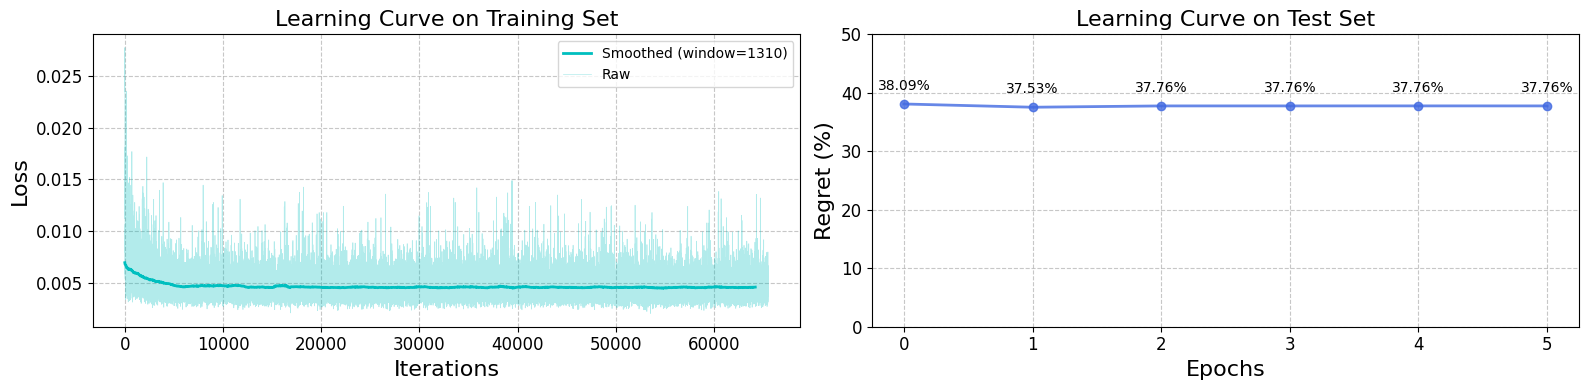

In [16]:
#############################################################################
# VISUALIZATION
#############################################################################
from matplotlib import pyplot as plt
import numpy as np


def visLearningCurve(loss_log, loss_log_regret):
    """Enhanced visualization with smoother curves and more information"""
    # Create figure and subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))
    
    # Plot training loss with smoothing for readability
    n_points = len(loss_log)
    
    # Apply smoothing for large datasets
    if n_points > 100:
        window_size = max(10, n_points // 50)
        smoothed_loss = np.convolve(loss_log, np.ones(window_size)/window_size, mode='valid')
        x_axis = np.arange(len(smoothed_loss))
        ax1.plot(x_axis, smoothed_loss, color="c", lw=2, label=f"Smoothed (window={window_size})")
        # Also plot the raw data with transparency
        ax1.plot(loss_log, color="c", lw=0.5, alpha=0.3, label="Raw")
        ax1.legend()
    else:
        # For smaller datasets, just plot the raw data
        ax1.plot(loss_log, color="c", lw=2)
    
    ax1.tick_params(axis="both", which="major", labelsize=12)
    ax1.set_xlabel("Iterations", fontsize=16)
    ax1.set_ylabel("Loss", fontsize=16)
    ax1.set_title("Learning Curve on Training Set", fontsize=16)
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # Draw plot for regret on test set
    epochs = np.arange(len(loss_log_regret))
    ax2.plot(epochs, [r*100 for r in loss_log_regret], 
             color="royalblue", marker='o', ls="-", alpha=0.8, lw=2)
    
    ax2.tick_params(axis="both", which="major", labelsize=12)
    ax2.set_ylim(0, max(50, max([r*100 for r in loss_log_regret])*1.1))  # Dynamic y-limit
    ax2.set_xlabel("Epochs", fontsize=16)
    ax2.set_ylabel("Regret (%)", fontsize=16)
    ax2.set_title("Learning Curve on Test Set", fontsize=16)
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    # Add values to points
    for i, r in enumerate(loss_log_regret):
        ax2.annotate(f"{r*100:.2f}%", 
                     (i, r*100),
                     textcoords="offset points", 
                     xytext=(0,10), 
                     ha='center')
    
    plt.tight_layout()
    # plt.savefig('learning_curves.png', dpi=300, bbox_inches='tight')
    # print("Saved learning curves to 'learning_curves.png'")
    plt.show()

print("\nVisualizing learning curves...")
visLearningCurve(loss_log, loss_log_regret)